<a href="https://colab.research.google.com/github/palaceIA/CICS_Project/blob/main/src/notebooks/distilbert/distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Distilbert

Esse jupyter faz parte na nossa pesquisa para o Congresso Internacional (CICS) , aqui você ira encontrar nosso experimento referente ao modelo DistilBert e os nossos devidos resultados. O dataset utlizado foi o "dair-ai/emotion" disponivel no HuggingFace .

## DistilBert-base-uncased

DistilBERT é um modelo de transformadores, menor e mais rápido que o BERT, que foi pré-treinado no mesmo corpus de forma autossupervisionada, usando o modelo base do BERT como professor. Isso significa que ele foi pré-treinado apenas nos textos brutos, sem humanos rotulando-os de forma alguma (é por isso que ele pode usar muitos dados disponíveis publicamente) com um processo automático para gerar entradas e rótulos desses textos usando o modelo base do BERT. Mais precisamente, ele foi pré-treinado com três objetivos:

Perda de destilação: o modelo foi treinado para retornar as mesmas probabilidades que o modelo base BERT.
Modelagem de linguagem mascarada (MLM): isso faz parte da perda de treinamento original do modelo base BERT. Ao pegar uma frase, o modelo mascara aleatoriamente 15% das palavras na entrada e então executa a frase mascarada inteira através do modelo e tem que prever as palavras mascaradas. Isso é diferente das redes neurais recorrentes tradicionais (RNNs) que geralmente veem as palavras uma após a outra, ou de modelos autorregressivos como GPT que mascaram internamente os tokens futuros. Ele permite que o modelo aprenda uma representação bidirecional da frase.
Perda de incorporação de cosseno: o modelo também foi treinado para gerar estados ocultos o mais próximo possível do modelo base BERT.
Dessa forma, o modelo aprende a mesma representação interna da língua inglesa que o modelo do professor, sendo mais rápido para inferência ou tarefas posteriores.

## Treinamento do modelo

O DistilBERT foi pré-treinado com os mesmos dados do BERT, que é o BookCorpus , um conjunto de dados que consiste em 11.038 livros não publicados e a Wikipédia em inglês (excluindo listas, tabelas e cabeçalhos).

In [1]:
# Instalando os modulos
!pip install torch transformers datasets matplotlib numpy scikit-learn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Carregando os modulos

In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    AutoTokenizer,
    AutoModel ,
    Trainer
)
from sklearn.metrics import (
    accuracy_score ,
    f1_score ,
    classification_report ,
    roc_curve ,
    auc
)
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

### Carregando o dataset

In [ ]:
id_data = "dair-ai/emotion"
dataset = load_dataset(id_data)

### Entendendo os dados

In [4]:
# Estrutura do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
# Total de classes do dataset
classes = dataset['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [6]:
# Alterando o formato do dataset para um tipo pandas
dataset.set_format(type='pandas')
df_pandas = dataset['train'][:]
df_pandas.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Criando uma tabela para cada classe correspondente
df_pandas['label_name'] = df_pandas['label'].apply(lambda x : classes[x])
df_pandas.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
# Verificando o balanceamento das classes
total_classes = df_pandas['label_name'].value_counts()
total_classes

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [9]:
# Resetando o formato original dos dados
dataset.reset_format()

### Carregando o tokenizador do modelo

In [ ]:
id_model = 'distilbert-base-uncased'
tokenizador = AutoTokenizer.from_pretrained(id_model)

In [11]:
# passaremos a quantidade de batchs dos dados
# Para aplicar essas a tokenizaço de todos os dados
# basta usar o metodo map()
# Função para tokenizar o dataset
def tokenizador_lote(batch):
    temp = tokenizador(
        batch['text'],  # Aqui, 'batch' deve ser um dicionário com uma chave 'text'
        padding=True,
        truncation=True,
    )
    return temp

### Tokenizando dados

In [ ]:
dataset_tokenizado = dataset.map(
    tokenizador_lote,
    batched = True ,
    batch_size=None
)

### Carregando modelo

In [ ]:
model= AutoModel.from_pretrained(id_model)

In [14]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

### Configurações iniciais para o ajuste fino

In [15]:
# Armazenando numero de classes
numero_classes = len(classes)
# Inicializando plataforma CUDA
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
model = AutoModelForSequenceClassification.from_pretrained(
    id_model , num_labels = numero_classes
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
device

device(type='cuda')

In [19]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [17]:
!nvidia-smi

Sat Apr  5 21:20:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Configurações do treinamento

In [20]:
# Tamanho do lote
batch_size = 15
model_name = 'distilbert-base-uncased-emotions'

training_args = TrainingArguments(
    output_dir=model_name ,
    num_train_epochs=4 ,
    learning_rate=1e-5,
    per_device_train_batch_size= batch_size ,
    per_device_eval_batch_size=batch_size ,
    weight_decay=0.01,
    eval_strategy='epoch' ,
    disable_tqdm=False

)

### Computação de métricas

In [21]:
def computer_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {"acurracy : " : acc , "f1" : f1}

### Treinamento

In [22]:
trainer = Trainer(
    model = model ,
    args = training_args ,
    compute_metrics = computer_metrics ,
    train_dataset = dataset_tokenizado['train'] ,
    eval_dataset= dataset_tokenizado['validation'] ,
    tokenizer = tokenizador
)

<ipython-input-22-fe59b000d80f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: caiopalacio16 (caiopalacio16-unifsa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acurracy :,F1
1,0.352400,0.228722,0.921500,0.922192
2,0.188300,0.173600,0.932000,0.931900
3,0.123600,0.164155,0.941500,0.941679
4,0.114600,0.163109,0.940000,0.940003


TrainOutput(global_step=4268, training_loss=0.2663104648107441, metrics={'train_runtime': 696.566, 'train_samples_per_second': 91.879, 'train_steps_per_second': 6.127, 'total_flos': 1440685723392000.0, 'train_loss': 0.2663104648107441, 'epoch': 4.0})

### Avaliando modelo

In [24]:
pred_ouptus = trainer.predict(
    dataset_tokenizado['test']
)
pred_ouptus.metrics

{'test_loss': 0.18985368311405182,
 'test_acurracy : ': 0.9245,
 'test_f1': 0.9242239678575195,
 'test_runtime': 4.0373,
 'test_samples_per_second': 495.377,
 'test_steps_per_second': 33.19}

In [25]:
y_pred = np.argmax(
    pred_ouptus.predictions,axis=1
)
y_test = dataset_tokenizado['test'][:]['label']

In [49]:
y_pred[:5]

array([0, 0, 0, 1, 0])

In [45]:
y_test[:5]

[0, 0, 0, 1, 0]

In [46]:
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [30]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.94      0.95       695
        love       0.81      0.86      0.83       159
       anger       0.92      0.92      0.92       275
        fear       0.88      0.90      0.89       224
    surprise       0.75      0.64      0.69        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [27]:
report_dict = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
report_dict

{'sadness': {'precision': 0.963855421686747,
  'recall': 0.963855421686747,
  'f1-score': 0.963855421686747,
  'support': 581.0},
 'joy': {'precision': 0.9492753623188406,
  'recall': 0.9424460431654677,
  'f1-score': 0.9458483754512635,
  'support': 695.0},
 'love': {'precision': 0.8058823529411765,
  'recall': 0.8616352201257862,
  'f1-score': 0.8328267477203647,
  'support': 159.0},
 'anger': {'precision': 0.9236363636363636,
  'recall': 0.9236363636363636,
  'f1-score': 0.9236363636363636,
  'support': 275.0},
 'fear': {'precision': 0.881578947368421,
  'recall': 0.8973214285714286,
  'f1-score': 0.8893805309734514,
  'support': 224.0},
 'surprise': {'precision': 0.75,
  'recall': 0.6363636363636364,
  'f1-score': 0.6885245901639344,
  'support': 66.0},
 'accuracy': 0.9245,
 'macro avg': {'precision': 0.8790380746585914,
  'recall': 0.8708763522582382,
  'f1-score': 0.8740120049386874,
  'support': 2000.0},
 'weighted avg': {'precision': 0.9244276775698839,
  'recall': 0.9245,
  'f

In [31]:
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

# Exibe a tabela
print(report_df)

              precision  recall  f1-score    support
sadness          0.9639  0.9639    0.9639   581.0000
joy              0.9493  0.9424    0.9458   695.0000
love             0.8059  0.8616    0.8328   159.0000
anger            0.9236  0.9236    0.9236   275.0000
fear             0.8816  0.8973    0.8894   224.0000
surprise         0.7500  0.6364    0.6885    66.0000
accuracy         0.9245  0.9245    0.9245     0.9245
macro avg        0.8790  0.8709    0.8740  2000.0000
weighted avg     0.9244  0.9245    0.9242  2000.0000


In [55]:
def plot_multiclass_roc(y_true, y_probs, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curvas ROC por Emoção')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [54]:
pred = trainer.predict(dataset_tokenizado['test'])

# Aplica softmax sobre os logits
y_pred_proba = softmax(pred.predictions, axis=1)

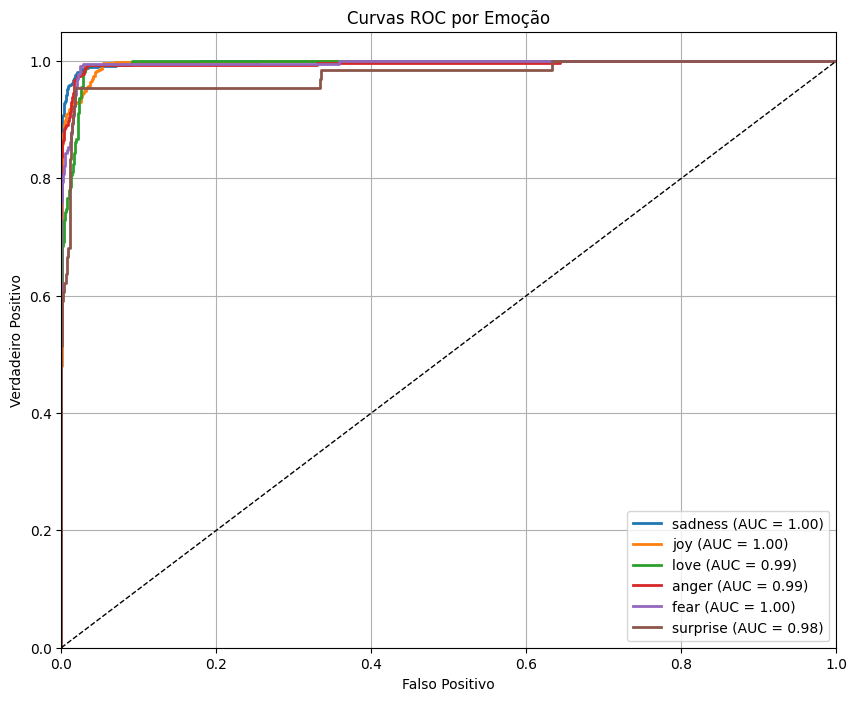

In [58]:
plot_multiclass_roc(y_test, y_pred_proba, classes)

In [68]:
def get_roc_dataframe(y_true, y_probs, class_names):
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    dataframes = []

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        df = pd.DataFrame({
            'class': classes[i],
            'fpr': fpr,
            'tpr': tpr,
            'threshold': thresholds,
            'auc': roc_auc  # mesmo valor repetido pra cada linha, pra facilitar agrupamentos
        })

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

In [71]:
roc_df = get_roc_dataframe(y_test, y_pred_proba,classes)
roc_df

,class,fpr,tpr,threshold,auc
0,sadness,0.000000,0.000000,inf,0.997829
1,sadness,0.000000,0.001721,0.998867,0.997829
2,sadness,0.000000,0.051635,0.998786,0.997829
3,sadness,0.000000,0.055077,0.998785,0.997829
4,sadness,0.000000,0.063683,0.998782,0.997829
...,...,...,...,...,...
443,surprise,0.334540,0.969697,0.000389,0.976137
444,surprise,0.334540,0.984848,0.000388,0.976137
445,surprise,0.632885,0.984848,0.000217,0.976137
446,surprise,0.632885,1.000000,0.000217,0.976137
